# TK Module 3

In [1]:
# load libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./USO.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '') 
df.columns = df.columns.str.lower()

In [4]:
df['log_close'] = np.log(df['close'])

In [5]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

In [6]:
def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_= pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
        x = pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x = x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [7]:
def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0

## Question 1

**find the minimum fractional dimension d that will turn this price series into a stationary series. (30 points)**



In [8]:
log_mind = findMinD(df[['log_close']])
norm_mind = findMinD(df[['close']])

print(f'log Min Dimensions: {log_mind}')
print(f'norm Min Dimensions: {norm_mind}')

log Min Dimensions: 0.5
norm Min Dimensions: 0.4


## Question 2

**Using the d you found in part 1 to fractionally differentiate the USO daily price series, use adfuller from statsmodels.tsa.stattools to determine the ADF statistics of the resulting time series. Can you conclude from these statistics that the fractionally differentiated time series is stationary? (20 points)**

Looking at the results for both the normal closing price and the log price, we can definitely conclude that the null hypothesis can be rejected.

For norm we get a critical value of -4.91 which is less than the T-values at 1, 5, and 10 percent confidence.

For logs we get a crit value of -3.76 which is less than the t-values at 1, 5, and 10 percent confidence. 

The p-value is also quite small, which indicates significance at even .01, .05, and .10

So we conclude that the fractionally differentiated time series is stationary.

In [9]:
q2_norm_df = fracDiff_FFD(df[['close']], log_mind, thres=0.01).dropna()
q2_log_df = fracDiff_FFD(df[['log_close']], log_mind, thres=0.01).dropna()

In [10]:
q2_norm_adfuller = adfuller(q2_norm_df,maxlag=1,regression='c',autolag=None)
q2_log_adfuller = adfuller(q2_log_df,maxlag=1,regression='c',autolag=None)

In [11]:
q2_norm_adfuller

(-4.910394309077451,
 3.328556787885713e-05,
 1,
 3297,
 {'1%': -3.4323349555967604,
  '5%': -2.862417036057391,
  '10%': -2.5672368644181542})

In [12]:
q2_log_adfuller

(-3.756688620019477,
 0.0033828660986467266,
 1,
 3297,
 {'1%': -3.4323349555967604,
  '5%': -2.862417036057391,
  '10%': -2.5672368644181542})

## Question 3

Complete Exercise 5.1 in AFML using the functions that we provided. (Each part carries 10 points for a total of 30 points)

**Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:**

1. **Compute the ADF statistic on this series. What is the p-value?**

    We get a p-value of 0.0 meaning there is 0% chance we do NOT reject the null hypothesis. 

2. **Compute the cumulative sum of the observations. This is a non-stationary series without memory.**
    1. **What is the order of integration of this cumulative series?**
    
        .3

    2. **Compute the ADF statistic on this series. What is the p-value?**

        .44

        
3. **Differentiate the series twice. What is the p-value of this over-differentiated series?**

    The over-differentiated series has a p-value of 0.


In [14]:
# create the series
example_series = pd.DataFrame(np.random.normal(0, 1, 10000), columns=['value'])

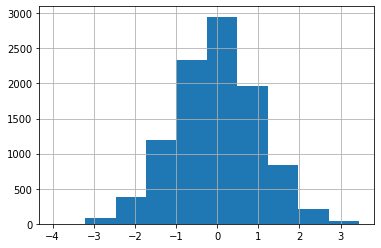

In [26]:
example_series['value'].hist();

In [18]:
# pvalue = example_adf[1]
example_adf = adfuller(example_series,maxlag=1,regression='c',autolag=None)
example_adf

(-71.8617364514084,
 0.0,
 1,
 9998,
 {'1%': -3.431004228818807,
  '5%': -2.8618291302145686,
  '10%': -2.566923898875394})

In [25]:
# cumusum
cumsum = example_series.cumsum()

In [24]:
# order of integration
example_mind = findMinD(cumsum)
example_mind

0.30000000000000004

In [28]:
# adf of cumsum
cumsum_adf = adfuller(cumsum,maxlag=1,regression='c',autolag=None)
cumsum_adf

(-1.5996220598387256,
 0.483783319774026,
 1,
 9998,
 {'1%': -3.431004228818807,
  '5%': -2.8618291302145686,
  '10%': -2.566923898875394})

In [31]:
# doublediff
once = fracDiff_FFD(cumsum, .3).dropna()
twice = fracDiff_FFD(once, .3).dropna()

ddiff = adfuller(twice,maxlag=1,regression='c',autolag=None)
ddiff

(-28.236540523227088,
 0.0,
 1,
 5450,
 {'1%': -3.4315504371879424,
  '5%': -2.8620704730694992,
  '10%': -2.5670523698005216})